In [1]:
%matplotlib inline

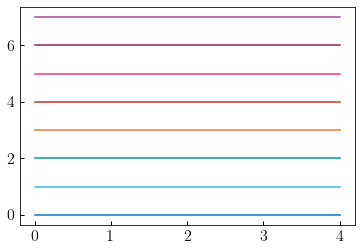

In [44]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from jax import numpy as jnp
from jax import jit as jjit
from jax import vmap
import os
import h5py
import time

mred = u"#d62728"
morange = u"#ff7f0e"
mgreen = u"#2ca02c"
mblue = u"#1f77b4"
mpurple = u"#9467bd"
plt.rc('font', family="serif")
plt.rc('font', size=22)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
colors = ["#0077BB", "#33BBEE", "#009988", "#EE7733", "#CC3311", "#EE3377", '#882255', '#AA4499']
for i, x in enumerate(colors):
    plt.plot(np.ones(5)*i, color=x)

# Define some basic quantities

In [3]:
from diffstar.constants import TODAY
from diffstar.stars import fstar_tools

# Define our cosmci time array to make some predictions
#t_table = np.linspace(0.1, TODAY, 100)
t_table = np.logspace(-1, np.log10(TODAY), 100)



# Define some mass bins for predictions
logm0_binmids = np.linspace(11.5, 13.5, 3)
logm0_bin_widths = np.ones_like(logm0_binmids) * 0.1


# Define some useful quantities and masks for later
fstar_tdelay = 1.0
index_select, index_high = fstar_tools(t_table, fstar_tdelay=fstar_tdelay)


sm_loss_weight = jnp.where(t_table>2.0, 1.0, 1e10)
fstar_loss_MS_weight = jnp.where(t_table[index_select]>2.0, 1.0, 1e10)
fstar_loss_Q_weight = jnp.where(t_table[index_select]>5.0, 1.0, 1e10)

sm_loss_sel = np.arange(len(t_table))[t_table>1.0]
fstar_loss_MS_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>2.0]
fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[t_table[index_select]>5.0]


# Generate some individual MAH histories with DiffmahPop

In [4]:
from diffmah.monte_carlo_halo_population import mc_halo_population

plt.figure

N = 10
logmpeak_diffmahpop = []
mah_params_diffmahpop = []

log_mahs = np.zeros((len(logm0_binmids), N, len(t_table)))
for i, binmid in enumerate(logm0_binmids):
    _res = mc_halo_population(t_table, TODAY, binmid * np.ones(N))
    _mahparams = np.array([
        np.ones(N)*np.log10(TODAY),
        binmid * np.ones(N),
        _res.lgtc,
        np.ones(N)*3.5,
        _res.early_index,
        _res.late_index,
    ]).T
    
    logmpeak_diffmahpop.append(binmid * np.ones(N))
    mah_params_diffmahpop.append(_mahparams)
    
    log_mahs[i] = _res.log_mah
    

    
logmpeak_diffmahpop = np.concatenate(logmpeak_diffmahpop)
mah_params_diffmahpop = np.concatenate(mah_params_diffmahpop)

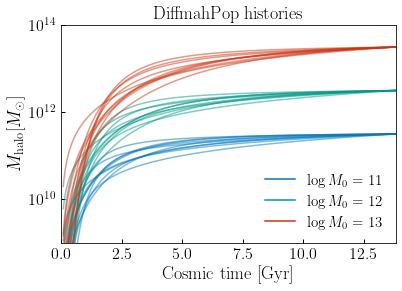

In [5]:
fig, ax = plt.subplots()

ax.plot(t_table, 10**log_mahs[0].T, colors[0], alpha=0.5)
ax.plot(t_table, 10**log_mahs[1].T, colors[2], alpha=0.5)
ax.plot(t_table, 10**log_mahs[2].T, colors[4], alpha=0.5)
ax.set_yscale('log')
ax.set_ylim(1e9, 1e14)
ax.set_xlim(0, TODAY)
ax.set_xlabel('Cosmic time [Gyr]')
ax.set_ylabel(r'$M_{\rm halo} [M_\odot]$')
ax.set_title("DiffmahPop histories")

legend_elements = [
    Line2D([0], [0], color=colors[0], label=r'$\log M_0 = %d$'%logm0_binmids[0]),
    Line2D([0], [0], color=colors[2], label=r'$\log M_0 = %d$'%logm0_binmids[1]),
    Line2D([0], [0], color=colors[4], label=r'$\log M_0 = %d$'%logm0_binmids[2]),
]
ax.legend(handles=legend_elements, loc=0)

plt.show()

# Generate some individual SFH histories with DiffstarPop

### Get the default DiffstarPOP parameters

In [6]:
from diffstarpop.pdf_quenched import DEFAULT_SFH_PDF_QUENCH_PARAMS
from diffstarpop.pdf_mainseq import DEFAULT_SFH_PDF_MAINSEQ_PARAMS

DEFAULT_SFH_PDF_QUENCH_PARAMS, DEFAULT_SFH_PDF_MAINSEQ_PARAMS

(OrderedDict([('frac_quench_x0', 12.06),
              ('frac_quench_k', 1.27),
              ('frac_quench_ylo', -0.81),
              ('frac_quench_yhi', 1.78),
              ('mean_ulgm_quench_ylo', 11.75),
              ('mean_ulgm_quench_yhi', 12.32),
              ('mean_ulgy_quench_ylo', 0.96),
              ('mean_ulgy_quench_yhi', -0.63),
              ('mean_ul_quench_ylo', -2.23),
              ('mean_ul_quench_yhi', 2.48),
              ('mean_utau_quench_ylo', 23.2),
              ('mean_utau_quench_yhi', -21.89),
              ('mean_uqt_quench_ylo', 1.67),
              ('mean_uqt_quench_yhi', -0.01),
              ('mean_uqs_quench_ylo', -3.61),
              ('mean_uqs_quench_yhi', 4.13),
              ('mean_udrop_quench_ylo', 0.33),
              ('mean_udrop_quench_yhi', -5.13),
              ('mean_urej_quench_ylo', 1.24),
              ('mean_urej_quench_yhi', -3.41),
              ('cov_ulgm_ulgm_quench_ylo', -1.0),
              ('cov_ulgm_ulgm_quench_yhi', -1.0

### Draw a few SFH histories


In [7]:
from diffstarpop.monte_carlo_halo_population import mc_sfh_population_draw


n_histories = 20
n_halos_per_bin = 10

t0 = time.time()
histories = mc_sfh_population_draw(
    t_table,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    mah_params_diffmahpop,
    n_histories,
    fstar_tdelay=1.0,
    population="MIX",
    pdf_parameters_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    pdf_parameters_Q=DEFAULT_SFH_PDF_QUENCH_PARAMS,
    diffstar_kernel="scan",
)
t1 = time.time()
print(t1-t0)

3.56951904296875


In [8]:
len(histories)

3

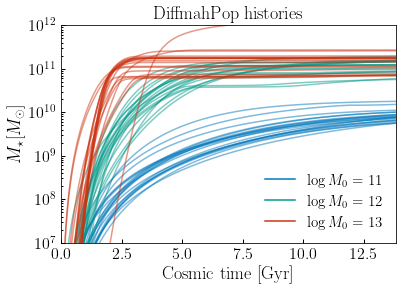

In [9]:
fig, ax = plt.subplots()

ax.plot(t_table, histories[0][0].T, colors[0], alpha=0.5)
ax.plot(t_table, histories[0][1].T, colors[2], alpha=0.5)
ax.plot(t_table, histories[0][2].T, colors[4], alpha=0.5)
ax.set_yscale('log')
ax.set_ylim(1e7, 1e12)
ax.set_xlim(0, TODAY)
ax.set_xlabel('Cosmic time [Gyr]')
ax.set_ylabel(r'$M_{\rm \star} [M_\odot]$')
ax.set_title("DiffmahPop histories")

legend_elements = [
    Line2D([0], [0], color=colors[0], label=r'$\log M_0 = %d$'%logm0_binmids[0]),
    Line2D([0], [0], color=colors[2], label=r'$\log M_0 = %d$'%logm0_binmids[1]),
    Line2D([0], [0], color=colors[4], label=r'$\log M_0 = %d$'%logm0_binmids[2]),
]
ax.legend(handles=legend_elements, loc=0)

plt.show()

# Calculate first and second order moments of Mstar, SFH with DiffstarPop drawing individual SFH histories


### Compare the calculations between two different `diffstar` kernel implementations using `vmap` or `scan` 

In [11]:
from diffstarpop.monte_carlo_halo_population import mc_sfh_population_sumstats
n_histories = int(1e5)
n_halos_per_bin = 10

t0 = time.time()
MC_res = mc_sfh_population_sumstats(
    t_table,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    mah_params_diffmahpop,
    n_histories,
    fstar_tdelay=1.0,
    population="MIX",
    pdf_parameters_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    pdf_parameters_Q=DEFAULT_SFH_PDF_QUENCH_PARAMS,
    diffstar_kernel="vmap",
)
t1 = time.time()
print(t1-t0)
t0 = time.time()
MC_res_scan = mc_sfh_population_sumstats(
    t_table,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    mah_params_diffmahpop,
    n_histories,
    fstar_tdelay=1.0,
    population="MIX",
    pdf_parameters_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    pdf_parameters_Q=DEFAULT_SFH_PDF_QUENCH_PARAMS,
    diffstar_kernel="scan",
)
t1 = time.time()
print(t1-t0)




/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/diffstarpop-0.0.dev0-py3.7.egg/diffstarpop/monte_carlo_halo_population.py:675: RuntimeWarning: Mean of empty slice
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/diffstarpop-0.0.dev0-py3.7.egg/diffstarpop/monte_carlo_halo_population.py:667: RuntimeWarning: divide by zero encountered in log10
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/diffstarpop-0.0.dev0-py3.7.egg/diffstarpop/monte_carlo_halo_population.py:668: RuntimeWarning: divide by zero encountered in log10
/Users/alarcon/anaconda3/anaconda3/envs/diffit/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


18.263306856155396
25.178385972976685


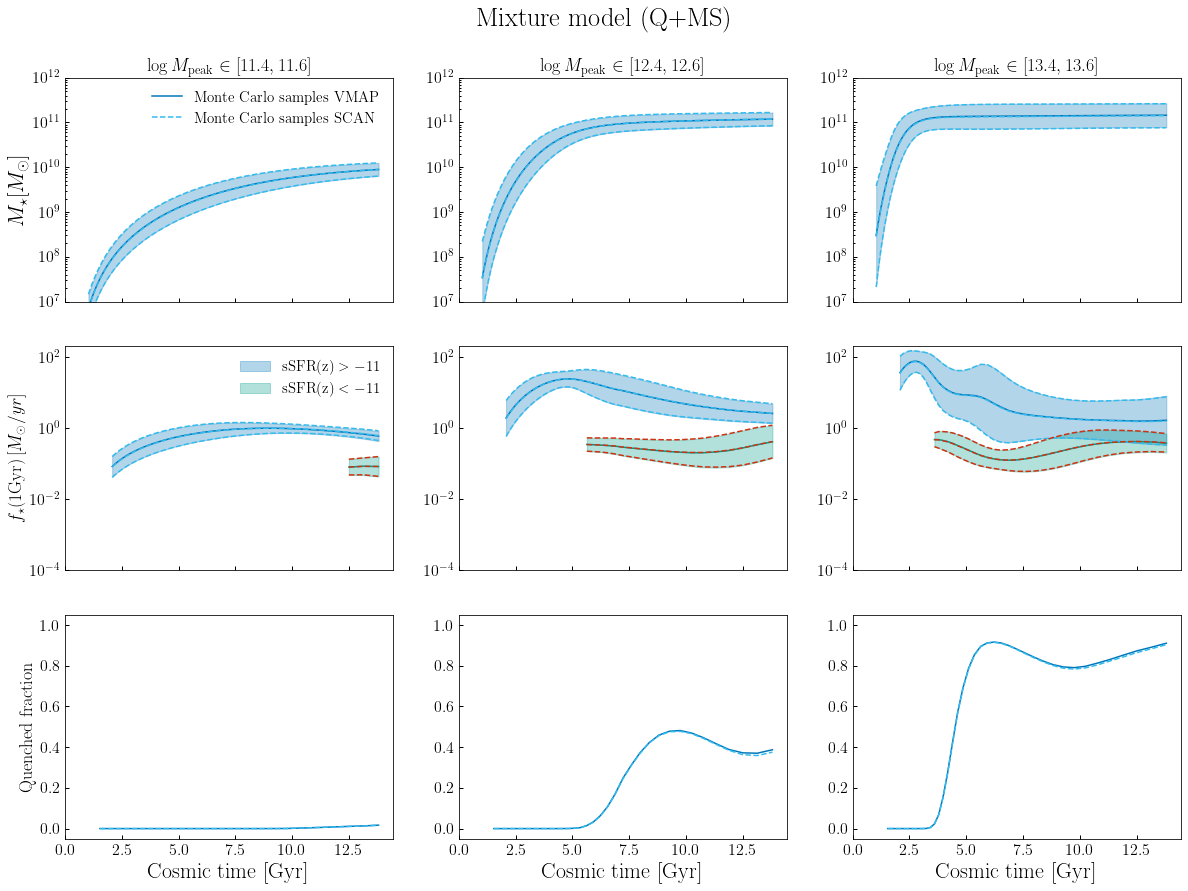

In [27]:
NM0 = len(logm0_binmids)


fontsize=22
fig, ax = plt.subplots(3,NM0, figsize=(20,14), sharex=True, sharey=False)

for i in range(NM0):
    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**MC_res[0][i][sm_loss_sel], color=colors[0], label='Monte Carlo samples VMAP')
    ax[0,i].fill_between(t_table[sm_loss_sel], 
                       10**(MC_res[0][i]-np.sqrt(MC_res[1][i]))[sm_loss_sel],
                       10**(MC_res[0][i]+np.sqrt(MC_res[1][i]))[sm_loss_sel],
                       color=colors[0],
                       alpha = 0.3         
                      )
    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**MC_res[2][i][fstar_loss_MS_sel], color=colors[0])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_MS_sel], 
                       10**(MC_res[2][i]-np.sqrt(MC_res[4][i]))[fstar_loss_MS_sel],
                       10**(MC_res[2][i]+np.sqrt(MC_res[4][i]))[fstar_loss_MS_sel],
                       color=colors[0],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) > -11$"         
                      )
    
    fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[(t_table[index_select]>fstar_tdelay)&(MC_res[6][i]>0.01)]
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**MC_res[3][i][fstar_loss_Q_sel], color=colors[2])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_Q_sel], 
                       10**(MC_res[3][i]-np.sqrt(MC_res[5][i]))[fstar_loss_Q_sel],
                       10**(MC_res[3][i]+np.sqrt(MC_res[5][i]))[fstar_loss_Q_sel],
                       color=colors[2],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) < -11$"      
                      )
                      
    ax[2,i].plot(t_table[index_select], MC_res[6][i], color=colors[0])
    
    
    ax[0,i].plot(t_table[sm_loss_sel], 10**MC_res_scan[0][i][sm_loss_sel], ls="--", color=colors[1], label='Monte Carlo samples SCAN')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(MC_res_scan[0][i]-np.sqrt(MC_res_scan[1][i]))[sm_loss_sel], ls="--", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(MC_res_scan[0][i]+np.sqrt(MC_res_scan[1][i]))[sm_loss_sel], ls="--", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**MC_res_scan[2][i][fstar_loss_MS_sel], ls="--", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(MC_res_scan[2][i]-np.sqrt(MC_res_scan[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(MC_res_scan[2][i]+np.sqrt(MC_res_scan[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)

    fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[(t_table[index_select]>fstar_tdelay)&(MC_res_scan[6][i]>0.01)]
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**MC_res_scan[3][i][fstar_loss_Q_sel], ls="--", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(MC_res_scan[3][i]-np.sqrt(MC_res_scan[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(MC_res_scan[3][i]+np.sqrt(MC_res_scan[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)

    ax[2,i].plot(t_table[index_select], MC_res_scan[6][i], ls="--", color=colors[1])
        

    
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 1e12)
    ax[1,i].set_ylim(1e-4, 2e2)
    ax[2,i].set_ylim(-0.05,1.05)
    ax[2,i].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,i].set_title(r'$\log M_{\rm peak}\in[%.1f, %.1f]$'%(logm0_binmids[i]-logm0_bin_widths[i], logm0_binmids[i]+logm0_bin_widths[i]))

ax[0,0].legend()
ax[1,0].legend()
ax[0,0].set_xticks(np.arange(0,13,2.5))
ax[0,0].set_ylabel('$M_\star [M_{\odot}]$', fontsize=fontsize)
ax[1,0].set_ylabel('$f_\star(1\mathrm{Gyr}) \,[M_{\odot}/yr]$')
ax[2,0].set_ylabel('Quenched fraction')
fig.suptitle("Mixture model (Q+MS)", y=0.95)
#fig.savefig('mc_vs_pdfweight_sumstats_MIX.png', bbox_inches='tight', dpi=300)
plt.show()




# Calculate first and second order moments of Mstar, SFH with DiffstarPop by laying a Latin Hypercube grid and PDF weighting the histories in each point.

In [16]:
from diffstarpop.pdfmodel import PDF_weight_sfh_population_sumstats_wrapper

n_sfh_param_grid = int(1e5)
n_halos_per_bin = 10
sfh_lh_sig = 3.0
halo_data = mah_params_diffmahpop[:, np.array([1,2,4,5])].T.copy() # We only need logm, logtauc, early, late
halo_data[1] = 10**halo_data[1] # We actually need tauc


t0 = time.time()
PDF_res_MIX_scan_vmap = PDF_weight_sfh_population_sumstats_wrapper(
    t_table,
    sfh_lh_sig,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data,
    fstar_tdelay,
    population_model="MIX", # Options are 
    diffstar_kernel="scan",
    diffstarpop_kernel="vmap",
    pdf_model_params_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    pdf_model_params_Q=DEFAULT_SFH_PDF_QUENCH_PARAMS,
)
t1 = time.time()
print(t1-t0)

225.66251921653748


Text(0.5, 0.95, 'Mixture model (Q+MS)')

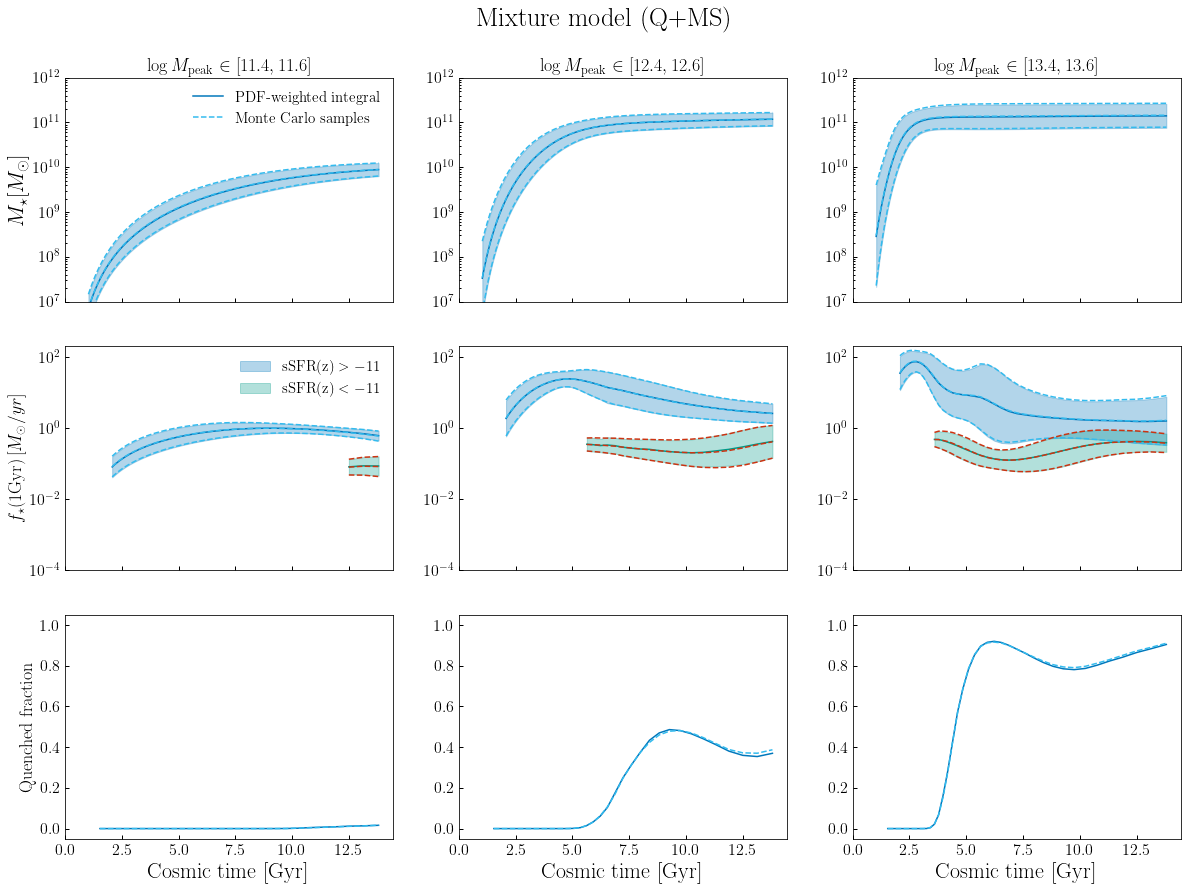

In [25]:
NM0 = len(logm0_binmids)


fontsize=22
fig, ax = plt.subplots(3,NM0, figsize=(20,14), sharex=True, sharey=False)

for i in range(NM0):
    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**PDF_res_MIX_scan_vmap[0][i][sm_loss_sel], color=colors[0], label='PDF-weighted integral')
    ax[0,i].fill_between(t_table[sm_loss_sel], 
                       10**(PDF_res_MIX_scan_vmap[0][i]-np.sqrt(PDF_res_MIX_scan_vmap[1][i]))[sm_loss_sel],
                       10**(PDF_res_MIX_scan_vmap[0][i]+np.sqrt(PDF_res_MIX_scan_vmap[1][i]))[sm_loss_sel],
                       color=colors[0],
                       alpha = 0.3         
                      )
    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**PDF_res_MIX_scan_vmap[2][i][fstar_loss_MS_sel], color=colors[0])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_MS_sel], 
                       10**(PDF_res_MIX_scan_vmap[2][i]-np.sqrt(PDF_res_MIX_scan_vmap[4][i]))[fstar_loss_MS_sel],
                       10**(PDF_res_MIX_scan_vmap[2][i]+np.sqrt(PDF_res_MIX_scan_vmap[4][i]))[fstar_loss_MS_sel],
                       color=colors[0],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) > -11$"         
                      )
    
    fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[(t_table[index_select]>fstar_tdelay)&(PDF_res_MIX_scan_vmap[6][i]>0.01)]
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**PDF_res_MIX_scan_vmap[3][i][fstar_loss_Q_sel], color=colors[2])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_Q_sel], 
                       10**(PDF_res_MIX_scan_vmap[3][i]-np.sqrt(PDF_res_MIX_scan_vmap[5][i]))[fstar_loss_Q_sel],
                       10**(PDF_res_MIX_scan_vmap[3][i]+np.sqrt(PDF_res_MIX_scan_vmap[5][i]))[fstar_loss_Q_sel],
                       color=colors[2],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) < -11$"      
                      )
                      
    ax[2,i].plot(t_table[index_select], PDF_res_MIX_scan_vmap[6][i], color=colors[0])
    
    
    ax[0,i].plot(t_table[sm_loss_sel], 10**MC_res[0][i][sm_loss_sel], ls="--", color=colors[1], label='Monte Carlo samples')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(MC_res[0][i]-np.sqrt(MC_res[1][i]))[sm_loss_sel], ls="--", color=colors[1],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(MC_res[0][i]+np.sqrt(MC_res[1][i]))[sm_loss_sel], ls="--", color=colors[1],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**MC_res[2][i][fstar_loss_MS_sel], ls="--", color=colors[1])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(MC_res[2][i]-np.sqrt(MC_res[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(MC_res[2][i]+np.sqrt(MC_res[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[1],)

    fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[(t_table[index_select]>fstar_tdelay)&(MC_res[6][i]>0.01)]
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**MC_res[3][i][fstar_loss_Q_sel], ls="--", color=colors[4])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(MC_res[3][i]-np.sqrt(MC_res[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(MC_res[3][i]+np.sqrt(MC_res[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[4],)

    ax[2,i].plot(t_table[index_select], MC_res[6][i], ls="--", color=colors[1])
        

    
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 1e12)
    ax[1,i].set_ylim(1e-4, 2e2)
    ax[2,i].set_ylim(-0.05,1.05)
    ax[2,i].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,i].set_title(r'$\log M_{\rm peak}\in[%.1f, %.1f]$'%(logm0_binmids[i]-logm0_bin_widths[i], logm0_binmids[i]+logm0_bin_widths[i]))

ax[0,0].legend()
ax[1,0].legend()
ax[0,0].set_xticks(np.arange(0,13,2.5))
ax[0,0].set_ylabel('$M_\star [M_{\odot}]$', fontsize=fontsize)
ax[1,0].set_ylabel('$f_\star(1\mathrm{Gyr}) \,[M_{\odot}/yr]$')
ax[2,0].set_ylabel('Quenched fraction')
fig.suptitle("Mixture model (Q+MS)", y=0.95)
#fig.savefig('mc_vs_pdfweight_sumstats_MIX.png', bbox_inches='tight', dpi=300)
plt.show()


## There are multiple kernel implementations available

In [28]:
# Pure SCAN version. Best memory efficiency, but slowest implementation.
# 10x slower than (diffstar:SCAN, diffstarpop:VMAP)
n_sfh_param_grid = int(1e4) #

t0 = time.time()
PDF_res_MIX_scan_scan = PDF_weight_sfh_population_sumstats_wrapper(
    t_table,
    sfh_lh_sig,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data,
    fstar_tdelay,
    population_model="MIX", # Options are 
    diffstar_kernel="scan",
    diffstarpop_kernel="scan",
    pdf_model_params_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    pdf_model_params_Q=DEFAULT_SFH_PDF_QUENCH_PARAMS,
)
t1 = time.time()
print(t1-t0)

# (diffstar:VMAP, diffstarpop:SCAN) version. 
# About 2x faster than using the opposite combination, (diffstar:SCAN, diffstarpop:VMAP), but more memory intensive.
n_sfh_param_grid = int(1e5)
t0 = time.time()
PDF_res_MIX_vmap_scan = PDF_weight_sfh_population_sumstats_wrapper(
    t_table,
    sfh_lh_sig,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data,
    fstar_tdelay,
    population_model="MIX", # Options are 
    diffstar_kernel="vmap",
    diffstarpop_kernel="scan",
    pdf_model_params_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    pdf_model_params_Q=DEFAULT_SFH_PDF_QUENCH_PARAMS,
)
t1 = time.time()
print(t1-t0)

229.80571389198303
101.13455200195312


In [35]:
# Only VMAP. Very memory intensive, very fast. Use with caution.

n_sfh_param_grid = int(1e4)
t0 = time.time()
PDF_res_MIX_vmap_vmap = PDF_weight_sfh_population_sumstats_wrapper(
    t_table,
    sfh_lh_sig,
    n_sfh_param_grid,
    logm0_binmids,
    logm0_bin_widths,
    n_halos_per_bin,
    halo_data,
    fstar_tdelay,
    population_model="MIX", # Options are 
    diffstar_kernel="vmap",
    diffstarpop_kernel="vmap",
    pdf_model_params_MS=DEFAULT_SFH_PDF_MAINSEQ_PARAMS,
    pdf_model_params_Q=DEFAULT_SFH_PDF_QUENCH_PARAMS,
)
t1 = time.time()
print(t1-t0)

12.398550987243652


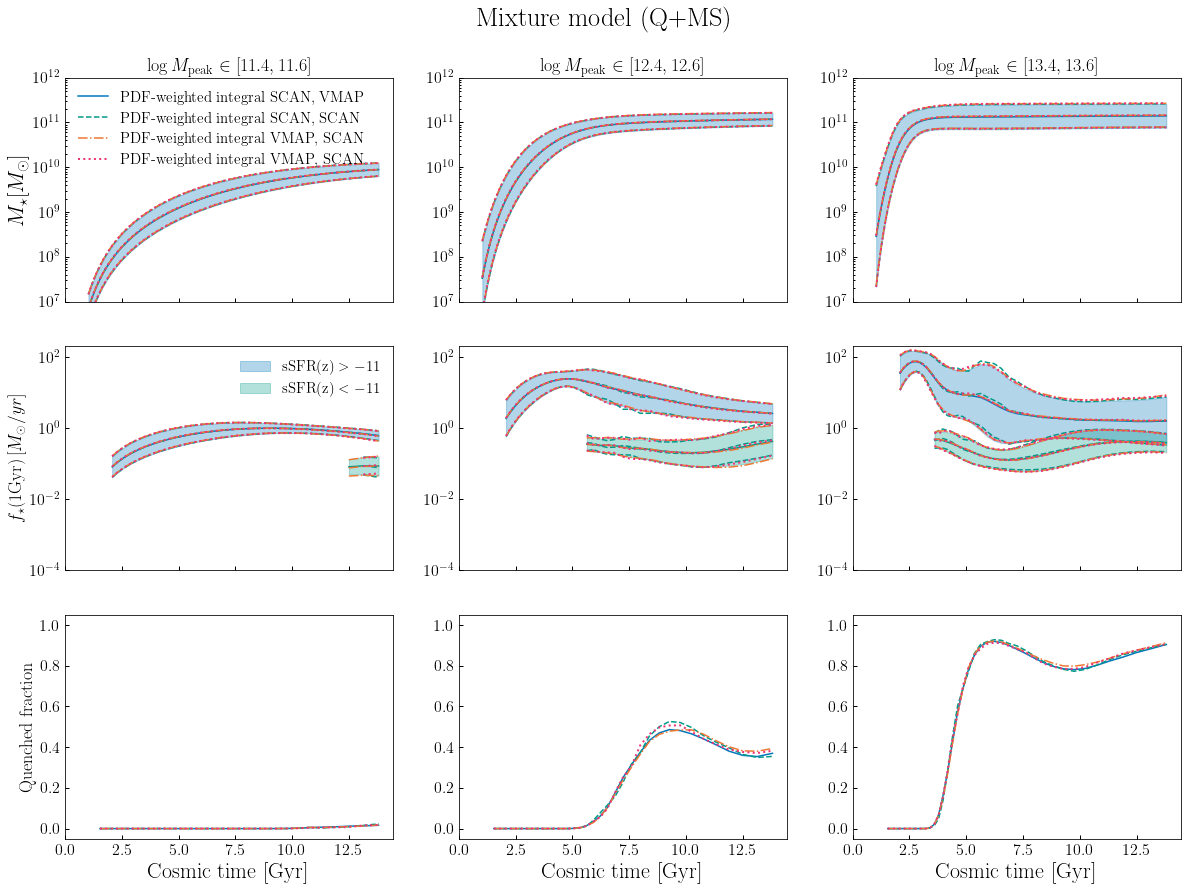

In [43]:
NM0 = len(logm0_binmids)


fontsize=22
fig, ax = plt.subplots(3,NM0, figsize=(20,14), sharex=True, sharey=False)

for i in range(NM0):
    #"""
    ax[0,i].plot(t_table[sm_loss_sel], 10**PDF_res_MIX_scan_vmap[0][i][sm_loss_sel], color=colors[0], label='PDF-weighted integral SCAN, VMAP')
    ax[0,i].fill_between(t_table[sm_loss_sel], 
                       10**(PDF_res_MIX_scan_vmap[0][i]-np.sqrt(PDF_res_MIX_scan_vmap[1][i]))[sm_loss_sel],
                       10**(PDF_res_MIX_scan_vmap[0][i]+np.sqrt(PDF_res_MIX_scan_vmap[1][i]))[sm_loss_sel],
                       color=colors[0],
                       alpha = 0.3         
                      )
    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**PDF_res_MIX_scan_vmap[2][i][fstar_loss_MS_sel], color=colors[0])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_MS_sel], 
                       10**(PDF_res_MIX_scan_vmap[2][i]-np.sqrt(PDF_res_MIX_scan_vmap[4][i]))[fstar_loss_MS_sel],
                       10**(PDF_res_MIX_scan_vmap[2][i]+np.sqrt(PDF_res_MIX_scan_vmap[4][i]))[fstar_loss_MS_sel],
                       color=colors[0],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) > -11$"         
                      )
    
    fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[(t_table[index_select]>fstar_tdelay)&(PDF_res_MIX_scan_vmap[6][i]>0.01)]
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**PDF_res_MIX_scan_vmap[3][i][fstar_loss_Q_sel], color=colors[2])
    ax[1,i].fill_between(t_table[index_select][fstar_loss_Q_sel], 
                       10**(PDF_res_MIX_scan_vmap[3][i]-np.sqrt(PDF_res_MIX_scan_vmap[5][i]))[fstar_loss_Q_sel],
                       10**(PDF_res_MIX_scan_vmap[3][i]+np.sqrt(PDF_res_MIX_scan_vmap[5][i]))[fstar_loss_Q_sel],
                       color=colors[2],
                       alpha = 0.3, label = r"$\rm{sSFR}(z) < -11$"      
                      )
                      
    ax[2,i].plot(t_table[index_select], PDF_res_MIX_scan_vmap[6][i], color=colors[0])
    
    ##################
    
    ax[0,i].plot(t_table[sm_loss_sel], 10**PDF_res_MIX_scan_scan[0][i][sm_loss_sel], ls="--", color=colors[2], label='PDF-weighted integral SCAN, SCAN')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(PDF_res_MIX_scan_scan[0][i]-np.sqrt(PDF_res_MIX_scan_scan[1][i]))[sm_loss_sel], ls="--", color=colors[2],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(PDF_res_MIX_scan_scan[0][i]+np.sqrt(PDF_res_MIX_scan_scan[1][i]))[sm_loss_sel], ls="--", color=colors[2],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**PDF_res_MIX_scan_scan[2][i][fstar_loss_MS_sel], ls="--", color=colors[2])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(PDF_res_MIX_scan_scan[2][i]-np.sqrt(PDF_res_MIX_scan_scan[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[2],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(PDF_res_MIX_scan_scan[2][i]+np.sqrt(PDF_res_MIX_scan_scan[4][i]))[fstar_loss_MS_sel], ls="--", color=colors[2],)

    fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[(t_table[index_select]>fstar_tdelay)&(PDF_res_MIX_scan_scan[6][i]>0.01)]
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**PDF_res_MIX_scan_scan[3][i][fstar_loss_Q_sel], ls="--", color=colors[2])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(PDF_res_MIX_scan_scan[3][i]-np.sqrt(PDF_res_MIX_scan_scan[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[2],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(PDF_res_MIX_scan_scan[3][i]+np.sqrt(PDF_res_MIX_scan_scan[5][i]))[fstar_loss_Q_sel], ls="--", color=colors[2],)

    ax[2,i].plot(t_table[index_select], PDF_res_MIX_scan_scan[6][i], ls="--", color=colors[2])
        
    ##################
    
    ax[0,i].plot(t_table[sm_loss_sel], 10**PDF_res_MIX_vmap_scan[0][i][sm_loss_sel], ls="-.", color=colors[3], label='PDF-weighted integral VMAP, SCAN')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(PDF_res_MIX_vmap_scan[0][i]-np.sqrt(PDF_res_MIX_vmap_scan[1][i]))[sm_loss_sel], ls="-.", color=colors[3],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(PDF_res_MIX_vmap_scan[0][i]+np.sqrt(PDF_res_MIX_vmap_scan[1][i]))[sm_loss_sel], ls="-.", color=colors[3],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**PDF_res_MIX_vmap_scan[2][i][fstar_loss_MS_sel], ls="-.", color=colors[3])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(PDF_res_MIX_vmap_scan[2][i]-np.sqrt(PDF_res_MIX_vmap_scan[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[3],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(PDF_res_MIX_vmap_scan[2][i]+np.sqrt(PDF_res_MIX_vmap_scan[4][i]))[fstar_loss_MS_sel], ls="-.", color=colors[3],)

    fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[(t_table[index_select]>fstar_tdelay)&(PDF_res_MIX_vmap_scan[6][i]>0.01)]
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**PDF_res_MIX_vmap_scan[3][i][fstar_loss_Q_sel], ls="-.", color=colors[3])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(PDF_res_MIX_vmap_scan[3][i]-np.sqrt(PDF_res_MIX_vmap_scan[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[3],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(PDF_res_MIX_vmap_scan[3][i]+np.sqrt(PDF_res_MIX_vmap_scan[5][i]))[fstar_loss_Q_sel], ls="-.", color=colors[3],)

    ax[2,i].plot(t_table[index_select], PDF_res_MIX_vmap_scan[6][i], ls="-.", color=colors[3])
    
    ##################
    
    ax[0,i].plot(t_table[sm_loss_sel], 10**PDF_res_MIX_vmap_vmap[0][i][sm_loss_sel], ls=":", lw=2.0, color=colors[5], label='PDF-weighted integral VMAP, SCAN')
    ax[0,i].plot(t_table[sm_loss_sel], 10**(PDF_res_MIX_vmap_vmap[0][i]-np.sqrt(PDF_res_MIX_vmap_vmap[1][i]))[sm_loss_sel], ls=":", lw=2.0, color=colors[5],)
    ax[0,i].plot(t_table[sm_loss_sel], 10**(PDF_res_MIX_vmap_vmap[0][i]+np.sqrt(PDF_res_MIX_vmap_vmap[1][i]))[sm_loss_sel], ls=":", lw=2.0, color=colors[5],)

    

    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**PDF_res_MIX_vmap_vmap[2][i][fstar_loss_MS_sel], ls=":", lw=2.0, color=colors[5])
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(PDF_res_MIX_vmap_vmap[2][i]-np.sqrt(PDF_res_MIX_vmap_vmap[4][i]))[fstar_loss_MS_sel], ls=":", lw=2.0, color=colors[5],)
    ax[1,i].plot(t_table[index_select][fstar_loss_MS_sel], 10**(PDF_res_MIX_vmap_vmap[2][i]+np.sqrt(PDF_res_MIX_vmap_vmap[4][i]))[fstar_loss_MS_sel], ls=":", lw=2.0, color=colors[5],)

    fstar_loss_Q_sel = np.arange(len(t_table[index_select]))[(t_table[index_select]>fstar_tdelay)&(PDF_res_MIX_vmap_vmap[6][i]>0.01)]
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**PDF_res_MIX_vmap_vmap[3][i][fstar_loss_Q_sel], ls=":", lw=2.0, color=colors[5])
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(PDF_res_MIX_vmap_vmap[3][i]-np.sqrt(PDF_res_MIX_vmap_vmap[5][i]))[fstar_loss_Q_sel], ls=":", lw=2.0, color=colors[5],)
    ax[1,i].plot(t_table[index_select][fstar_loss_Q_sel], 10**(PDF_res_MIX_vmap_vmap[3][i]+np.sqrt(PDF_res_MIX_vmap_vmap[5][i]))[fstar_loss_Q_sel], ls=":", lw=2.0, color=colors[5],)

    ax[2,i].plot(t_table[index_select], PDF_res_MIX_vmap_vmap[6][i], ls=":", lw=2.0, color=colors[5])
    
    ##################
    
    ax[0,i].set_yscale('log')
    ax[1,i].set_yscale('log')
    ax[0,i].set_ylim(1e7, 1e12)
    ax[1,i].set_ylim(1e-4, 2e2)
    ax[2,i].set_ylim(-0.05,1.05)
    ax[2,i].set_xlabel('Cosmic time [Gyr]', fontsize=fontsize)
    ax[0,i].set_title(r'$\log M_{\rm peak}\in[%.1f, %.1f]$'%(logm0_binmids[i]-logm0_bin_widths[i], logm0_binmids[i]+logm0_bin_widths[i]))

ax[0,0].legend()
ax[1,0].legend()
ax[0,0].set_xticks(np.arange(0,13,2.5))
ax[0,0].set_ylabel('$M_\star [M_{\odot}]$', fontsize=fontsize)
ax[1,0].set_ylabel('$f_\star(1\mathrm{Gyr}) \,[M_{\odot}/yr]$')
ax[2,0].set_ylabel('Quenched fraction')
fig.suptitle("Mixture model (Q+MS)", y=0.95)
#fig.savefig('mc_vs_pdfweight_sumstats_MIX.png', bbox_inches='tight', dpi=300)
plt.show()
